## Configs

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import math
from datetime import datetime

from utils.bs_funcs import *

%load_ext autoreload
%autoreload 2

## Options Data

In [2]:
## Dates
# start_dt = datetime(2024, 1, 1) 
# start = f'{start_dt.year}-{start_dt.month}-{start_dt.day}'
# end_dt = datetime.today()
# end = f'{end_dt.year}-{end_dt.month}-{end_dt.day}'

## download stock data
ticker = 'BOVA11'
yf_ticker = [f'{ticker}.SA']
stock_df =  get_stock_data(yf_ticker, period='1Y')
S = stock_df.iloc[-1]['Close']  # Preço Ação
print(f'Current Underlying Price: {S:.2f}')

[*********************100%%**********************]  1 of 1 completed

Current Underlying Price: 125.30


In [3]:
exp_date_front = '2024-08-16'
            
options_chain_front = get_options_chain(ticker, exp_date_front) 
options_chain_front[options_chain_front['Strike'] == int(S)].sort_values('abs_Distance').head(2)

,Option,Type,E/A,Moneyness,Strike,Distance,Premium,volume,abs_Distance
24,BOVAH125,CALL,E,ATM,125.0,-0.24,1.29,4019234.26,0.24
104,BOVAT125,PUT,E,ATM,125.0,-0.24,0.98,2468844.23,0.24


In [4]:
## Collect back month data to get the strikes and premium of the operation
exp_date_back = '2024-09-20'
            
options_chain_back = get_options_chain(ticker, exp_date_back)
options_chain_back[options_chain_back['Strike'] == int(S)].sort_values('abs_Distance').head(2)

,Option,Type,E/A,Moneyness,Strike,Distance,Premium,volume,abs_Distance
24,BOVAI125,CALL,E,ATM,125.0,-0.24,3.14,3039132.47,0.24
107,BOVAU125,PUT,E,ATM,125.0,-0.24,1.81,2223507.50,0.24


## Rets/Vol

In [5]:
r = 0.1025 # taxa livre de risco # automatiza depois

K = options_chain_back[(options_chain_back['Moneyness'] == 'ATM') & (options_chain_back['Type'] == 'CALL')].sort_values('abs_Distance')[:1]['Strike'].iloc[0] # Strike 
dte = (datetime.strptime(exp_date_back, '%Y-%m-%d') - datetime.today()).days # dia ate venciemnto  
T = dte/252   # ano até vencmento
market_price = options_chain_back[(options_chain_back['Moneyness'] == 'ATM') & (options_chain_back['Type'] == 'CALL')].sort_values('abs_Distance')[:1]['Premium'].iloc[0]  # Market price of the option

In [6]:
cc_vol = realized_cc_vol(stock_df['Close'], dte)
pk_vol = parkinson_volatility(stock_df) * np.sqrt(dte/252) ## this parkinson function returns annual 

print(f'Vol: {cc_vol:.2%}')
print(f'Vol: {pk_vol:.2%}')

Vol: 5.60%
Vol: 4.69%


In [7]:
# sigma = realized_cc_vol(stock_df['Close'], dte)
sigma = parkinson_volatility(stock_df) * np.sqrt(dte/252)

rets = stock_df[['Close']].pct_change().dropna()
mu = annualize_rets(rets, dte)

## Expected Move

In [8]:
ann_sigma = realized_cc_vol(stock_df['Close'])

## short options will be where straddle breaks-even
atm_straddle_short(options_chain_back, S)

atm_straddle_approximation_short(S, ann_sigma, dte)

mad_straddle_approximation_short(S, ann_sigma, dte)

ATM Straddle: 4.95
Range Expectation using ATM Straddle 120.35 e 130.25
ATM Straddle: 7.01
Range Expectation using ATM Straddle Approximation 118.29 e 132.31
MAD Straddle: 5.61
Range Expectation using MAD Straddle 119.69 e 130.91


(5.609453341172723, 119.69054971058509, 130.90945639293054)

## Profit-to-Loss Ratio

In [9]:
wing_width = 3 
long_put_strike, short_put_strike, short_call_strike, long_call_strike = select_iron_condor_strikes(function=atm_straddle_short, options=options_chain_back, S=S, wing_width=wing_width)

ATM Straddle: 4.95
Range Expectation using ATM Straddle 120.35 e 130.25


In [10]:
max_loss, gain_range, credit_received, profit, roc_cost, leg_width = iron_condor(options_chain_back, long_put_strike, short_put_strike, short_call_strike, long_call_strike, qty=1)

Position Risk: 2.17
Gain Range: 10.00
Credit Received/Max Profit: $0.83
Managed Take Profit: $0.43
Managed ROIC (net): 19.89%


## Monte Carlo/Kelly Criterion

In [11]:
steps_per_year = 252
n_scenarios = 10000
n_years = dte/252

In [12]:
paths = gbm(n_years, n_scenarios, mu, sigma, steps_per_year, S)

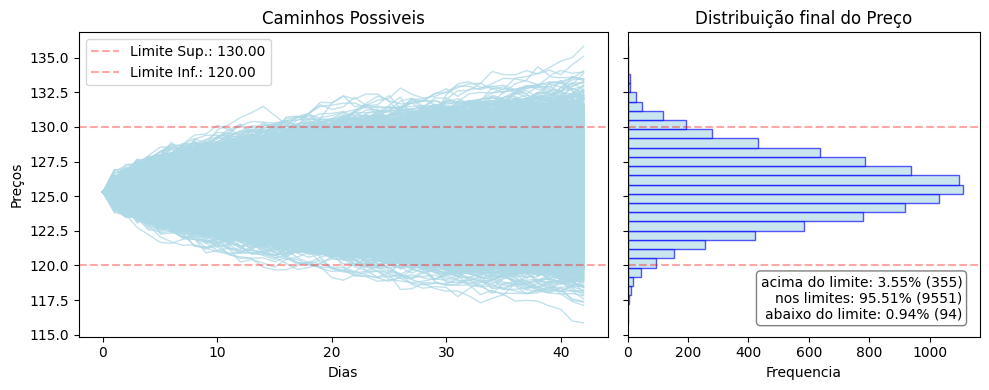

In [13]:
win_pct, loss_above, loss_bellow = plot_paths(paths, ceiling=short_call_strike, floor=short_put_strike)

In [14]:
kelly_fraction, max_risk = kelly_criterion(win_pct, roc_cost, bet_factor=.25, portfolio_size=110)

print(f'Kelly Factor of total portfolio for this trade: {kelly_fraction:.2%} ')
print(f'Max Risk of this trade: R$ {max_risk:.2f}')

Kelly Factor of total portfolio for this trade: 18.23% 
Max Risk of this trade: R$ 20.06


In [15]:
qty = math.floor(max_risk/max_loss)
iron_condor(options_chain_back, long_put_strike, short_put_strike, short_call_strike, long_call_strike, qty=qty)

Position Risk: 19.53
Gain Range: 10.00
Credit Received/Max Profit: $7.47
Managed Take Profit: $34.96
Managed ROIC (net): 19.89%


(19.53, 10.0, 0.8300000000000001, 3.8844000000000007, 0.1988940092165899, 3.0)

In [16]:
## Black and Scholes Prices 
long_put_price = black_scholes(S, long_put_strike, T, r, ann_sigma, 'p')
short_put_price = black_scholes(S, short_put_strike, T, r, ann_sigma, 'p')
short_call_price = black_scholes(S, short_call_strike, T, r, ann_sigma, 'c')
long_call_price = black_scholes(S, long_call_strike, T, r, ann_sigma, 'c')
straddle_bs_price = long_put_price - short_put_price + short_call_price - long_call_price

print(f'Long Put Strike {long_put_strike}: price {long_put_price:.2f}')
print(f'Short Put Strike {short_put_strike}: price {short_put_price:.2f}')
print(f'Short Call Strike {short_call_strike}: price {short_call_price:.2f}')
print(f'Long Call Strike {long_call_strike}: price {long_call_price:.2f}')
print(f'ATM Straddle: price {straddle_bs_price:.2f}')

print(f'BS ROIC: {straddle_bs_price / (wing_width - straddle_bs_price):.2%}') 

Long Put Strike 117.0: price 0.18
Short Put Strike 120.0: price 0.49
Short Call Strike 130.0: price 1.75
Long Call Strike 133.0: price 0.92
ATM Straddle: price 0.52
BS ROIC: 21.13%


[Iron Condor](https://optionalpha.com/strategies/iron-condor)  
[Volatility Estimators](https://portfoliooptimizer.io/blog/range-based-volatility-estimators-overview-and-examples-of-usage/)